# Data exploration
This notebook contains some tests about data import and some data viz tools

In [1]:
DATA_FOLDER = './data/'
MOVIES_FOLDER = DATA_FOLDER + 'movies_summaries/'
PLOT_SUMMARY_FOLDER = DATA_FOLDER + 'corenlp_plot_summaries'
KAGGLE_FOLDER = DATA_FOLDER + 'kaggle/'

REPORT_FOLDER = './gen/reports/'
ETHNICITY_FILE = './gen/ethnicities.tsv'
INFLATION_FILE = DATA_FOLDER + 'inflation_data.csv'

CHARACTERS_FILE = MOVIES_FOLDER + 'character.metadata.tsv'
MOVIES_FILE = MOVIES_FOLDER + 'movie.metadata.tsv'
PLOT_SUMMARIES_FILE = MOVIES_FOLDER + 'plot_summaries.txt'
TROPES_FILE = MOVIES_FOLDER + 'tvtropes.clusters.txt'

KAGGLE_FILE = KAGGLE_FOLDER + 'movies_metadata.csv'

# country to study in this notebook
TARGET_COUNTRIES = ['United States of America']

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.graph_objects as go

# from pandas_profiling import ProfileReport
%matplotlib inline

from data_wrangling_tools import *

# Dataset
The cells of this section contains the code to load the different datasets, merge them and clean them.  
The different datasets are the following:  
From the CMU dataset (data/movies_summaries): TODO change this folder name  
* characters.metadata.tsv
* movies.metadata.tsv

From the Kaggle movies dataset (data/kaggle):
* movies_metadata.csv

In [3]:
# data loading example
# ethnicity_clusters = {1: 'White', 2: 'Black / African American', 3: 'Asian', 
#     4: 'American Indian / Alaska Native', 5: 'Native Hawaiian / Other Pacific Islander',
#     6: 'Other'}

# df_tmp = generate_clean_df(CHARACTERS_FILE, ETHNICITY_FILE, MOVIES_FILE,
#     KAGGLE_FILE, INFLATION_FILE, ethnicity_clusters)

# df_tmp

### Load CMU movies dataset
Here, we load the movies from the CMU movies dataset.  
Some processing steps are applied in order to clean the features:
* The unknown values in `countries`, `genres` and `languages` are set the "Unknown"
* The json features `countries`, `genres` and `languages` are converted to python lists
  
Then, the dataset is filtered in order to consider only the movies created in the U.S. TODO change it

In [4]:
# load movies
def load_cmu_movies(movies_file):
    """
        TODO fill it
    """
    movies_columns = ['wiki_movie_id', 'freebase_movie_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
    movies = pd.read_csv(movies_file, sep='\t', names=movies_columns) 

    # clean dates
    movies['release_date'] = pd.to_datetime(movies['release_date'], format='%Y-%m-%d', errors='coerce')

    return movies


movies_cmu = load_cmu_movies(MOVIES_FILE)

In [5]:
# clean features    
def clean_unknowns(input_df, features=['countries', 'genres', 'languages']):
    """
        Replace unkown values in countries, genres and languages
    """

    def replace_unknown(df, label):
        """
            Replace emtpy json with "Unknown"
        """
        return df[label].replace("{}", "{\"\": \"Unknown\"}")
    
    df = input_df.copy()

    for feature in features:
        df[feature] = replace_unknown(df, feature)

    return df


def clean_jsons(df_input, features=['countries', 'genres', 'languages']):
    """
        Replace json dictionnaries for countries, genres and languages
    """

    def extract_feature(json_):
        """
            Replace json dictionnaries with list of their values
        """
        if json_ is np.nan:
            return np.nan
        return list(ast.literal_eval(json_).values())

    df = df_input.copy()
    
    for feature in features:
        df[feature] = df[feature].apply(extract_feature)

    return df


movies_cmu = clean_unknowns(movies_cmu)
movies_cmu = clean_jsons(movies_cmu)

### Select only U.S. movies
Our analysis is based only on U.S. movies. Thus, we'll filter the movies dataset to keep only those movies.

In [6]:
def filter_with_countries(df, target_countries, mode):
    """
        TODO fill it
    """
    # TODO drop na on every columns ?
    if mode == 'all':
        return df[df["countries"].apply(lambda x: all(country in x for country in target_countries))]
    elif mode == 'any':
        return df[df["countries"].apply(lambda x: any(country in x for country in target_countries))]
    elif mode == 'only':
        return df[df["countries"].apply(lambda x: set(x) == set(target_countries))]
    else:
        raise ValueError('mode must be one of [all, any, only]')

nb_prev = movies_cmu.shape[0]
print('Number of movies in the whole dataset: {}'.format(movies_cmu.shape[0]))

# select only movies from the US
movies_cmu = filter_with_countries(movies_cmu, TARGET_COUNTRIES, 'any')
print('Number of movies produced in the U.S.: {} ({:.2%} of the whole dataset)'.format(movies_cmu.shape[0], movies_cmu.shape[0] / nb_prev))

print('The Movies CMU dataset contains U.S. movies from {} to {}'.format(int(movies_cmu['release_date'].dt.year.min()), int(movies_cmu['release_date'].dt.year.max())))
movies_cmu.head()

Number of movies in the whole dataset: 81741
Number of movies produced in the U.S.: 34408 (42.09% of the whole dataset)
The Movies CMU dataset contains U.S. movies from 1890 to 2016


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
5,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi..."
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]"
10,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]"


### Load Kaggle movies dataset
The Kaggle movies are not used to add movies that are missing in the CMU movies dataset, but to add missing information about the movies present in the CMU movies dataset, such as IMDB ratings, missing box office and budget.

In [7]:
# import kaggle dataset
def load_kaggle_movies(kaggle_file, columns=['original_title', 'revenue', 'budget', 'vote_average', 'vote_count', 'release_date']):
    """
        TODO fill it
    """
    kaggle = pd.read_csv(kaggle_file, usecols=columns)

    # remove wrongly formatted rows (only 3)
    kaggle = kaggle.drop(kaggle[kaggle['budget'].str.contains('.jpg')].index)

    # convert date string to datetime objects
    kaggle['release_date'] = pd.to_datetime(kaggle['release_date'], format='%Y-%m-%d', errors='coerce')

    # convert numerical columns to float
    kaggle['revenue'] = kaggle['revenue'].astype(float).apply(lambda x: np.nan if x == 0.0 else x)
    kaggle['budget'] = kaggle['budget'].astype(float).apply(lambda x: np.nan if x == 0.0 else x)

    return kaggle


movies_kaggle = load_kaggle_movies(KAGGLE_FILE)
print(movies_kaggle.shape)
movies_kaggle.head()

(45463, 6)


,budget,original_title,release_date,revenue,vote_average,vote_count
0,30000000.0,Toy Story,1995-10-30,373554033.0,7.7,5415.0
1,65000000.0,Jumanji,1995-12-15,262797249.0,6.9,2413.0
2,NaN,Grumpier Old Men,1995-12-22,NaN,6.5,92.0
3,16000000.0,Waiting to Exhale,1995-12-22,81452156.0,6.1,34.0
4,NaN,Father of the Bride Part II,1995-02-10,76578911.0,5.7,173.0


### Check whether the Kaggle dataset can be trusted
Before adding information from the Kaggle dataset, we need to check whether the Kaggle dataset can be trusted. 
We will do so by checking whether the box office revenue in the CMU dataset and in the Kaggle
dataset are the same.  
As you can see below, the box office revenue information is the same for every movie.

In [8]:
df_trust = pd.merge(movies_cmu, movies_kaggle, left_on=[movies_cmu['name'], movies_cmu['release_date'].dt.year], 
                    right_on=[movies_kaggle['original_title'], movies_kaggle['release_date'].dt.year], how='left')
df_trust = df_trust.rename({'release_date_x': 'release_date', 'revenue':'box_office_revenue_kaggle'}, axis=1)
df_trust = df_trust.drop(columns=['original_title', 'key_0', 'key_1', 'release_date_y'])

# select only the rows where the box office revenue is known
df_trust = df_trust[(df_trust['box_office_revenue'].notna()) & (df_trust['box_office_revenue_kaggle'].notna())]

df_trust['box_office_revenue'] = df_trust['box_office_revenue'].astype(float)
df_trust['box_office_revenue_kaggle'] = df_trust['box_office_revenue'].astype(float)

# compare all values
is_same = np.allclose(df_trust['box_office_revenue'].to_numpy(), df_trust['box_office_revenue_kaggle'].to_numpy())

print("Are the values from Kaggle and the values from the movies dataset are the same? {}".format(is_same))

Are the values from Kaggle and the values from the movies dataset are the same? True


Now that we know that we can trust the Kaggle dataset, we will add the missing information in the CMU dataset.

In [9]:
def merge_cmu_kaggle_movies(movies, kaggle):
    """
        TODO fill it and rename this function
    """
    df = pd.merge(movies, kaggle, left_on=[movies['name'], movies['release_date'].dt.year], 
        right_on=[kaggle['original_title'], kaggle['release_date'].dt.year], how='left')
    df = df.rename({'release_date_x': 'release_date'}, axis=1)

    # fill the box_office revenue with the kaggle revenue if it's missing
    df['box_office_revenue'] = df['box_office_revenue'].fillna(df['revenue'].copy())
    df = df.drop(columns=['revenue', 'original_title', 'key_0', 'key_1', 'release_date_y'])
    
    return df


movies = merge_cmu_kaggle_movies(movies_cmu, movies_kaggle)

print(movies.shape)
movies.head()

(34431, 12)


,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,vote_average,vote_count
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",28000000.0,4.8,299.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN,NaN
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"[Silent film, English Language]",[United States of America],"[Short Film, Silent film, Indie, Black-and-whi...",NaN,NaN,NaN
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",2000000.0,4.8,6.0
4,175026,/m/017n1p,Sarah and Son,1930-01-01,NaN,86.0,[English Language],[United States of America],"[Drama, Black-and-white]",NaN,NaN,NaN


### Add inflation data
TODO update to add budget too  
In order to be able to compare the movies from different years, we will correct the box office revenue and the budget for inflation. This means that all revenues will be expressed by the amount they would be if the movie have been released in 2022.  
  
In order to do so, we'll need to import the "inflation_data.csv" file which contains the following inflation data for the U.S., for each year:
* Amount: buying power of 1$ from 1914 in year `n`. In other word, how much 1$ from 1914 is valued in year `n`.
* Inflation rate: inflation rate at each given year

After importing it, use the following formula to compute the value of 1$ from 2016 in every other year:

$bo_{inflation} = \frac{bo_{base}(year_n) * i(year_{2022})}{i(year_n)}$  

In the cell below, we already the factor to get the value of the box office in year `n` to the 2022 budget. Then, we plot graphs which shows the buying power of 1$ of 1914 increasing over the years.

In [10]:
def load_inflation(inflation_file):
    """
        TODO fill it
    """

    inflation = pd.read_csv(inflation_file, index_col='year')
    inflation = inflation.rename(columns={'amount': 'amount_1900'})	

    reference_year = 2022
    inflation_reference_year = inflation.loc[reference_year, 'amount_1900']

    inflation['amount_2022'] = inflation['amount_1900'].apply(lambda x: inflation_reference_year / x)

    return inflation
    

inflation = load_inflation(INFLATION_FILE)

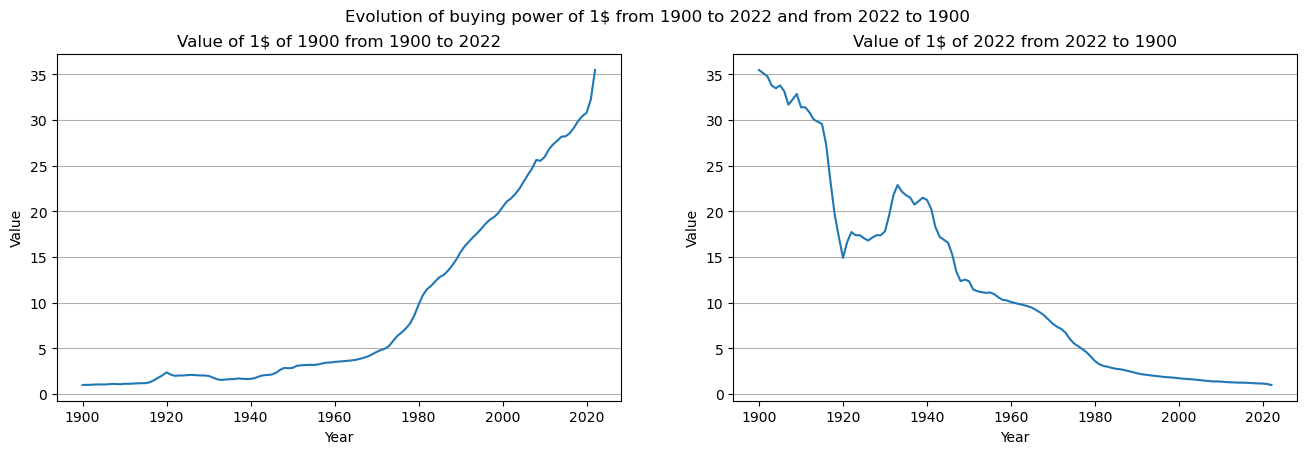

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4.5))

fig.suptitle('Evolution of buying power of 1$ from 1900 to 2022 and from 2022 to 1900')

ax[0].plot(inflation['amount_1900'])
ax[0].set_title('Value of 1$ of 1900 from 1900 to 2022')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Value')
ax[0].grid(axis='y')


# plot from 2022 to 1900
ax[1].plot(inflation.index, inflation['amount_2022'].values)
ax[1].set_title('Value of 1$ of 2022 from 2022 to 1900')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Value')
ax[1].grid(axis='y')
plt.show()

# Data exploration on the movies dataset
Now that we have loaded all the necessary datasets, we will do some data exploration on the movies.

### Missing values
In the following cells, we will analyze the number of missing values that we have in the columns of interest.

In [12]:
# TODO show how many box office revenue information we've gained by using the Kaggle dataset

In [13]:
# number of nan box office values
nb_nan_movies = movies['box_office_revenue'].isna().sum()
print('Number of known box office values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan box office values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies_cmu.shape[0]))

nb_non_nan_movies = movies_cmu.shape[0] - nb_nan_movies
nb_non_nan_merged_movies = movies.shape[0] - nb_nan_movies
print('Number of box office values gained with kaggle: {} ({:.2%})'.format(nb_non_nan_merged_movies - nb_non_nan_movies, (nb_non_nan_merged_movies - nb_non_nan_movies) / nb_non_nan_movies))

Number of known box office values: 7704 (22.38%)
Number of nan box office values: 26727 (77.68%)
Number of box office values gained with kaggle: 23 (0.30%)


In [14]:
# number of nan release date values
nb_nan_movies = movies['release_date'].isna().sum()
print('Number of known release date values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan release date values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known release date values: 33220 (96.48%)
Number of nan release date values: 1211 (3.52%)


In [15]:
# number of nan budget values
nb_nan_movies = movies['budget'].isna().sum()
print('Number of known budget values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan budget values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known budget values: 4604 (13.37%)
Number of nan budget values: 29827 (86.63%)


### Keep only movies with box office revenue
Because our analysis is focused on the box office revenue, we will only keep the movies for which we have a box office revenue.

In [16]:
movies = movies[movies['box_office_revenue'].notna()]

In the following cells, we see that the movies have almost all a release date too. Because there's only 13 movies for which the release that is not provided, we will add this information by hand.

In [17]:
# number of nan release date values
nb_nan_movies = movies['release_date'].isna().sum()
print('Number of known release date values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan release date values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known release date values: 7691 (99.83%)
Number of nan release date values: 13 (0.17%)


In [18]:
# Number of budget values
nb_nan_movies = movies['budget'].isna().sum()
print('Number of known release date values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan release date values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known release date values: 3846 (49.92%)
Number of nan release date values: 3858 (50.08%)


In [19]:
# number of nan budget values
nb_nan_movies = movies['budget'].isna().sum()
print('Number of known budget values: {} ({:.2%})'.format(movies.shape[0] - nb_nan_movies, (movies.shape[0] - nb_nan_movies) / movies.shape[0]))
print('Number of nan budget values: {} ({:.2%})'.format(nb_nan_movies, nb_nan_movies / movies.shape[0]))

Number of known budget values: 3846 (49.92%)
Number of nan budget values: 3858 (50.08%)


In [20]:
# movies[movies['release_date'].isna()].sort_values(by='box_office_revenue', ascending=False)

# TODO maybe for the 13 movies, we can just add the release date manually
# TODO check those release because they've been generated with copilot
def add_missing_release_date(movies):
    missing_release_dates = {
        'The Impossible': '2012-10-11',
        'The Outing': '1987-09-11',
        'Into the Spider\'s Web': '2007-08-26',
        'Melissa P.': '2005-11-18',
        'The Lamp': '2011-08-01',
        'The Bear': '1988-10-19',
        'Meatballs III: Summer Job': '1987-02-21',
        'The Steel Trap': '1952-11-12',
        'Angels Die Hard': '1970-06-01',
        'American Cyborg: Steel Warrior': '1994-01-07', 
        'Shattered Image': '1998-12-04',
        'The Ghost of Slumber Mountain': '1918-11-17',
        'Iron Warrior': '1987-01-09'
    }

    for movie_name, release_date in missing_release_dates.items():
        movies.loc[movies['name'] == movie_name, 'release_date'] = pd.to_datetime(release_date)

    return movies

add_missing_release_date(movies)

assert(movies['release_date'].isna().sum() == 0)

In [21]:
# correct box office revenue and budget with inflation
# TODO set it somewhere else, before the analysis (or add the inflation part here)
def add_inflation_data(movies, inflation):
    def inflation_adjustment(row, column):
        if np.isnan(row[column]):
            return np.nan
            
        return row[column] * inflation.loc[row['release_date'].year, 'amount_2022']
    
    movies['box_office_inflation'] = movies.apply(lambda x: inflation_adjustment(x, 'box_office_revenue'), axis=1)
    movies['budget_inflation'] = movies.apply(lambda x: inflation_adjustment(x, 'budget'), axis=1)

    return movies

movies = add_inflation_data(movies, inflation)

### Box office with inflation
Now that the inflation is contained in the data, we can compare the evolution of the movies box office revenue based on different values: 
* The average box office revenue for each year, with and without inflation
* The largest box office revenue for each year, with and without inflation

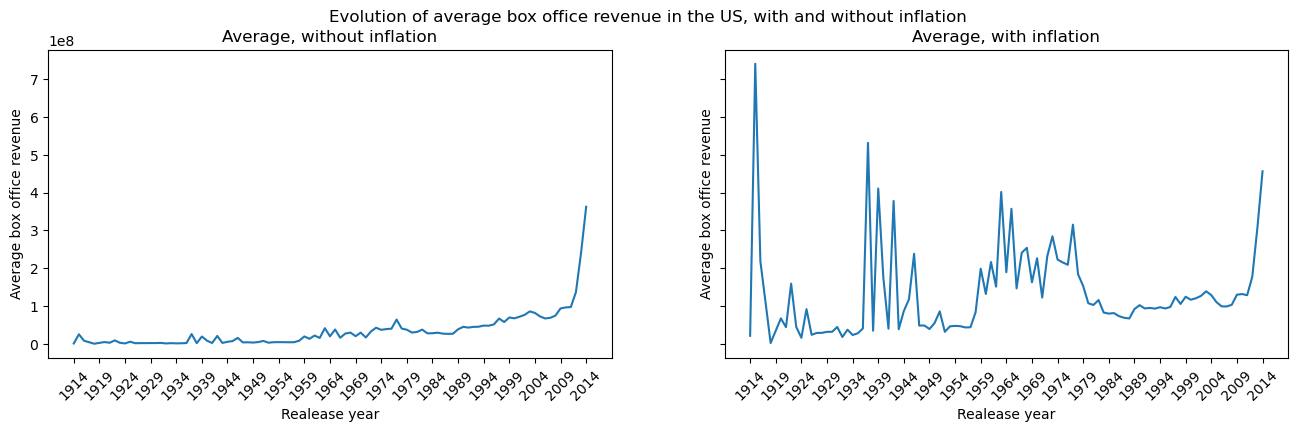

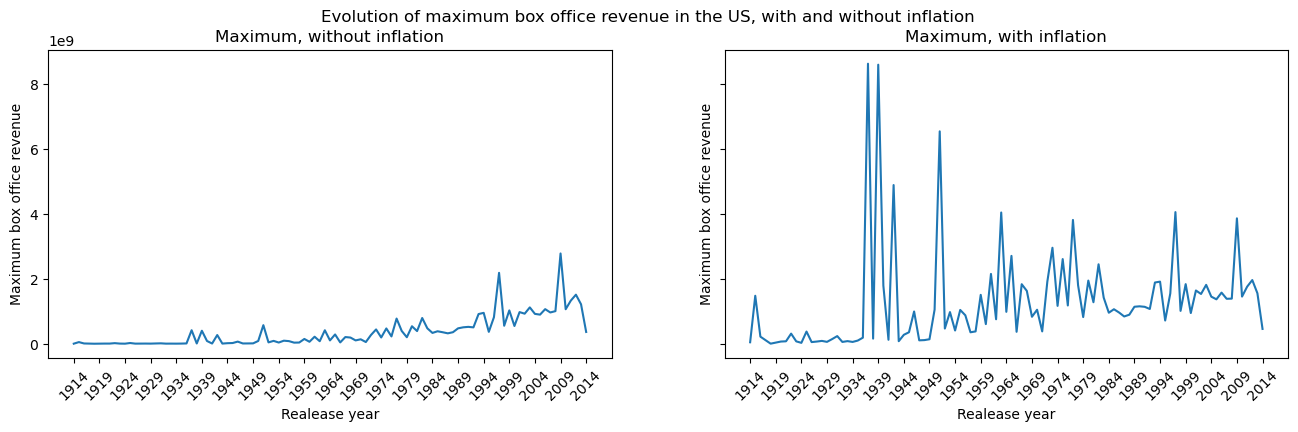

In [22]:
def plot_over_years(df, ax, column, metrics, title, ylabel):   
    """
        metrics: 'mean' or 'max'
    """ 
    ax.plot(df[column][metrics])
    ax.set_title(title)
    ax.set_xlabel('Realease year')
    ax.set_ylabel(ylabel)

    plt.sca(ax)
    plt.xticks(np.arange(1914, 2015, 5), rotation=45) # np.arange(1914, 2015, 5), 


box_office_year = movies.groupby(movies['release_date'].dt.year)[['box_office_revenue', 'box_office_inflation']].agg(['mean', 'max']).sort_index()


# Average
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

fig.suptitle('Evolution of average box office revenue in the US, with and without inflation')

plot_over_years(box_office_year, ax[0], 'box_office_revenue', 'mean', 'Average, without inflation', 'Average box office revenue')
plot_over_years(box_office_year, ax[1], 'box_office_inflation', 'mean','Average, with inflation', 'Average box office revenue')

plt.show()

# Maximum
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

fig.suptitle('Evolution of maximum box office revenue in the US, with and without inflation')

plot_over_years(box_office_year, ax[0], 'box_office_revenue', 'max','Maximum, without inflation', 'Maximum box office revenue')
plot_over_years(box_office_year, ax[1], 'box_office_inflation', 'max','Maximum, with inflation', 'Maximum box office revenue')

plt.show()

Top 10 movies with the highest box office revenue in the US, with and without inflation

In [23]:
# store them to compare them with the budget
top_10_bo = movies.sort_values(by='box_office_inflation', ascending=False)[['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']].head(10)

movies.sort_values(by='box_office_inflation', ascending=False)[['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']].head(10)

,name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation
5056,Snow White and the Seven Dwarfs,1937-12-21,4.160000e+08,8.631392e+09,1488423.0,3.088260e+07
15981,Gone with the Wind,1939-12-15,4.000000e+08,8.601212e+09,4000000.0,8.601212e+07
23794,Alice in Wonderland,1951-07-26,5.720000e+08,6.546632e+09,3000000.0,3.433548e+07
524,Bambi,1942-08-08,2.674472e+08,4.891250e+09,858000.0,1.569167e+07
9403,Titanic,1997-11-01,2.185372e+09,4.057405e+09,200000000.0,3.713239e+08
2971,Love with the Proper Stranger,1963-12-25,4.150049e+08,4.045157e+09,NaN,NaN
10025,Avatar,2009-12-10,2.782275e+09,3.865118e+09,237000000.0,3.292388e+08
34033,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,3.815689e+09,NaN,NaN
9984,The Exorcist,1973-06-19,4.410710e+08,2.958261e+09,8000000.0,5.365595e+07
18394,The Sound of Music,1965-03-02,2.862143e+08,2.707969e+09,8200000.0,7.758293e+07


### Budget with inflation
Caveat: the movies without budget information are not present in this graph

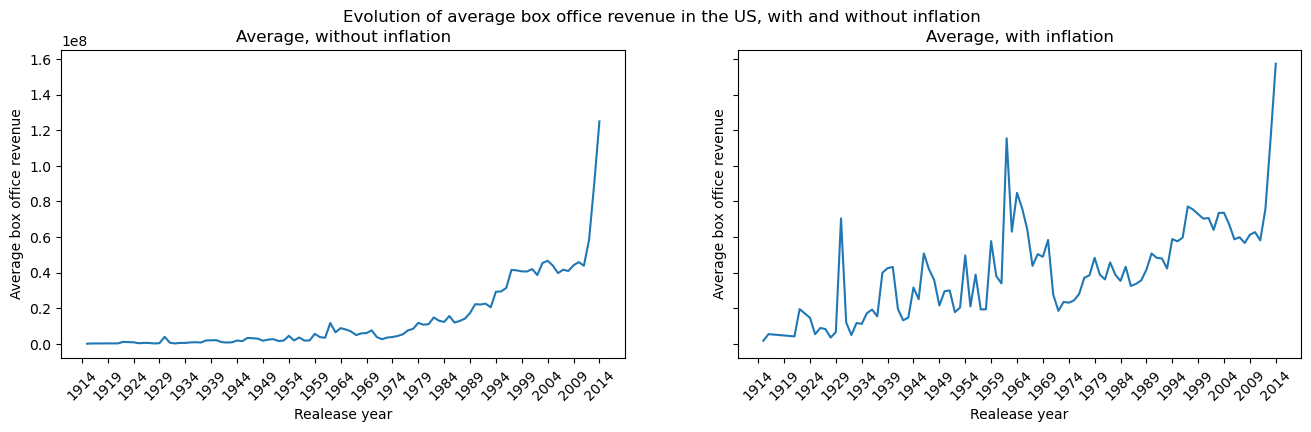

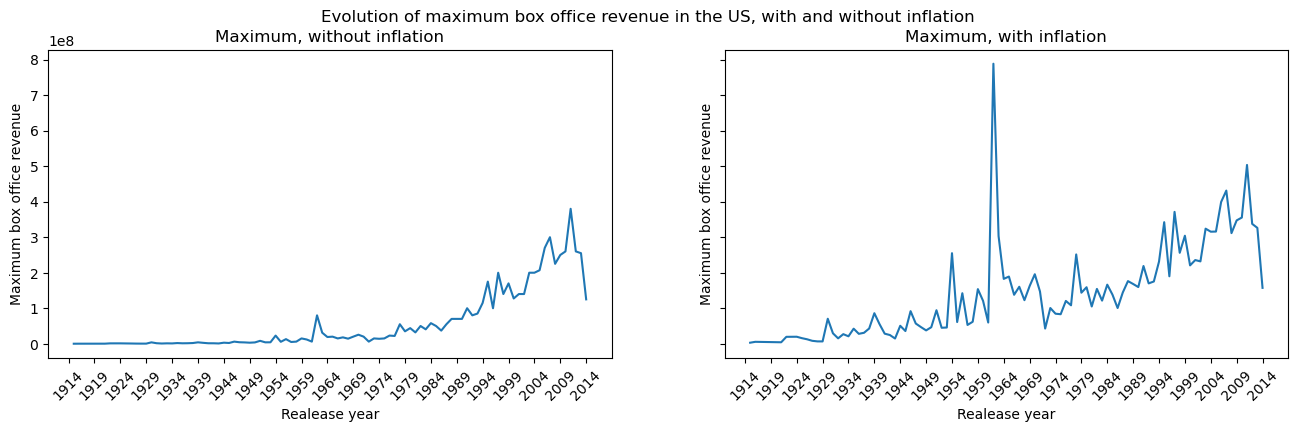

In [24]:
revenue_year = movies[movies['budget'].notna()].groupby(movies['release_date'].dt.year)[['budget', 'budget_inflation']].agg(['mean', 'max']).sort_index()

# Average
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

fig.suptitle('Evolution of average box office revenue in the US, with and without inflation')

plot_over_years(revenue_year, ax[0], 'budget', 'mean', 'Average, without inflation', 'Average box office revenue')
plot_over_years(revenue_year, ax[1], 'budget_inflation', 'mean','Average, with inflation', 'Average box office revenue')

plt.show()

# Maximum
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

fig.suptitle('Evolution of maximum box office revenue in the US, with and without inflation')

plot_over_years(revenue_year, ax[0], 'budget', 'max','Maximum, without inflation', 'Maximum box office revenue')
plot_over_years(revenue_year, ax[1], 'budget_inflation', 'max','Maximum, with inflation', 'Maximum box office revenue')

plt.show()

Top 10 movies with the highest box office revenue in the US, with and without inflation

In [25]:
top_10_budget = movies.sort_values(by='budget_inflation', ascending=False)[['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']].head(10)

movies.sort_values(by='budget_inflation', ascending=False)[['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']].head(10)

,name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation
25341,The Manchurian Candidate,1962-10-24,7.716923e+06,7.605456e+07,80000000.0,7.884444e+08
5987,Pirates of the Caribbean: On Stranger Tides,2011-05-07,1.043872e+09,1.382994e+09,380000000.0,5.034503e+08
30993,Pirates of the Caribbean: At World's End,2007-05-19,9.634204e+08,1.385014e+09,300000000.0,4.312804e+08
18355,Superman Returns,2006-06-21,3.910812e+08,5.781484e+08,270000000.0,3.991500e+08
9403,Titanic,1997-11-01,2.185372e+09,4.057405e+09,200000000.0,3.713239e+08
13763,Spider-Man 3,2007-04-16,8.908716e+08,1.280718e+09,258000000.0,3.709011e+08
32287,Tangled,2010-11-24,5.907219e+08,8.073503e+08,260000000.0,3.553467e+08
3067,Harry Potter and the Half-Blood Prince,2009-07-06,9.344165e+08,1.298085e+09,250000000.0,3.472984e+08
24098,Waterworld,1995-07-28,2.642182e+08,5.167840e+08,175000000.0,3.422822e+08
27100,John Carter,2012-03-08,2.827781e+08,3.671045e+08,260000000.0,3.375338e+08


In [26]:
print("Movies within the top 10 highest budget and highest box office revenue:")
movies.loc[top_10_bo.index.intersection(top_10_budget.index)][['name', 'release_date', 'box_office_revenue', 'box_office_inflation', 'budget', 'budget_inflation']]

Movies within the top 10 highest budget and highest box office revenue:


,name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation
9403,Titanic,1997-11-01,2.185372e+09,4.057405e+09,200000000.0,3.713239e+08


### Number of movies per year
Here, we plot the distribution of the number of movies produced every year

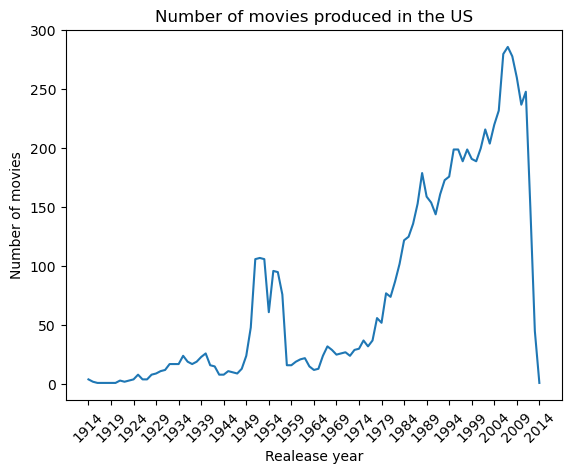

In [27]:
# plot the distribution of the number of movies produced each year
nb_movies_year = movies['release_date'].dt.year.value_counts().sort_index()


nb_movies_year.plot(legend=False)

plt.title('Number of movies produced in the US')
plt.xlabel('Realease year')
plt.ylabel('Number of movies')

# plt.grid(axis='y', color='grey', linestyle='--', alpha=0.5)
# for i in range(1914, 2015, 5):
#     plt.axvline(i, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.arange(1914, 2015, 5), rotation=45)

plt.show()

# Load characters
Here, we load the characters from the CMU movie dataset.

In [28]:
def load_characters(character_file):
    """
        TODO fill it
    """
    character_columns = ['wiki_movie_id', 'freebase_movie_id', 'm_release_date', 'name', 'a_dob', 'a_gender', 'a_height', 'a_ethnicity_freebase_id', 'a_name', 'a_age_at_release', 'freebase_char/a_map', 'freebase_char_id', 'freebase_a_id']
    characters = pd.read_csv(character_file, sep='\t', names=character_columns, index_col=False)

    # convert date string to datetime objects
    characters['m_release_date'] = pd.to_datetime(characters['m_release_date'], format='%Y-%m-%d', errors='coerce')

    # drop useless columns
    characters = characters.drop(['freebase_char/a_map', 'freebase_char_id', 'freebase_a_id'], axis=1)

    return characters


characters = load_characters(CHARACTERS_FILE)
print(characters.shape)
characters.head()

(450669, 10)


,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_ethnicity_freebase_id,a_name,a_age_at_release
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0


# Load ethnicities
In the following cell, we load the ethnicities and merge them with the characters dataframe.  
By doing so, every character row will contain its ethnicity name (if available).  
The different ethnicites are:
* 1 : White
* 2 : Black / African American
* 3 : Asian
* 4 : American Indian / Alaska Native
* 5 : Native Hawaiian / Other Pacific Islander
* 6 : Other (e.g. Aboriginal/Indigenous Australien)
  
Every ethicity is followed by another encoding, defined with + or -:
* \- : Not Hispanic or Latino
* \+ : Hispanic or Latino

This list of ethnicities has been generated based on the official U.S. xxx TODO fill it [link](link)

In [29]:
def load_ethnicities(ethnicity_file, etchnicity_clusters):
    """
        TODO fill it
    """
    ethnicities = pd.read_csv(ethnicity_file, sep='\t', header=None, names=['freebase_ethnicity_id', 'ethnicity_name', 'cluster_id', 'is_hispanic'])

    ethnicities['ethnicity_cluster_name'] = ethnicities['cluster_id'].map(etchnicity_clusters)
    ethnicities['is_hispanic'] = ethnicities['is_hispanic'].map({'-': 0, '+': 1}).astype(int)

    return ethnicities


ethnicity_clusters = {1: 'White', 2: 'Black / African American', 3: 'Asian', 
    4: 'American Indian / Alaska Native', 5: 'Native Hawaiian / Other Pacific Islander',
    6: 'Other'}

ethnicities = load_ethnicities(ETHNICITY_FILE, ethnicity_clusters)
ethnicities.head()

,freebase_ethnicity_id,ethnicity_name,cluster_id,is_hispanic,ethnicity_cluster_name
0,/m/0x67,African Americans,2,0,Black / African American
1,/m/064b9n,Omaha people,4,0,American Indian / Alaska Native
2,/m/041rx,Jewish people,1,0,White
3,/m/033tf_,Irish Americans,1,0,White
4,/m/04gfy7,Indian Americans,3,0,Asian


In [30]:
# add ethnicities in the characters dataframe
def add_characters_ethnicities(characters, ethnicities):
    """
        TODO fill it
    """
    df = characters.copy()
    df = pd.merge(left=characters, right=ethnicities, left_on='a_ethnicity_freebase_id', right_on='freebase_ethnicity_id', how='left')
    df = df.drop(['a_ethnicity_freebase_id', 'freebase_ethnicity_id', 'ethnicity_name', 'cluster_id'], axis=1)
    df = df.rename(columns={'ethnicity_cluster_name': 'a_ethnicity', 'is_hispanic': 'a_is_hispanic'})

    return df


characters = add_characters_ethnicities(characters, ethnicities)
characters.head()

,wiki_movie_id,freebase_movie_id,m_release_date,name,a_dob,a_gender,a_height,a_name,a_age_at_release,a_is_hispanic,a_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,NaN,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,0.0,Black / African American
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,NaN,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,NaN,NaN


# Add characters for every movie
TODO maybe load the characters here.  
TODO add more information (how we merge them and why).  
In the following cells, we add the characters in every movies, by doing a merge between the two datasets.

In [31]:
# merge characters and movies
def merge_characters_movies(characters, movies):
    """
        TODO fill it
    """
    # Movies and characters
    df = pd.merge(left=characters, right=movies, on='wiki_movie_id', how='right', suffixes=('_c', '_m'))

    # clean features
    duplicate_columns = ['freebase_movie_id_c', 'release_date']
    df = df.drop(duplicate_columns, axis=1)
    df = df.rename(columns={'freebase_movie_id_m': 'freebase_movie_id', 'name_c': 'char_name', 'name_m': 'movie_name', 'm_release_date': 'release_date'})

    # change order of columns
    df = df[['wiki_movie_id', 
            'freebase_movie_id', 'movie_name', 'release_date', 
            'box_office_revenue', 'box_office_inflation',
            'budget', 'budget_inflation', 'runtime', 'genres',
            'languages', 'countries', 'char_name', 'a_name', 
            'a_gender', 'a_ethnicity', 'a_is_hispanic', 'a_dob', 'a_age_at_release', 
            'a_height', 'vote_count', 'vote_average']]

    return df


df = merge_characters_movies(characters, movies)

print('The dataset contains: {} rows'.format(df.shape[0]))
df.head(3)

The dataset contains: 96559 rows


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation,runtime,genres,...,char_name,a_name,a_gender,a_ethnicity,a_is_hispanic,a_dob,a_age_at_release,a_height,vote_count,vote_average
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",...,Akooshay,Wanda De Jesus,F,NaN,NaN,1958-08-26,42.0,1.620,299.0,4.8
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",...,Lieutenant Melanie Ballard,Natasha Henstridge,F,NaN,NaN,1974-08-15,27.0,1.780,299.0,4.8
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",...,Desolation Williams,Ice Cube,M,Black / African American,0.0,1969-06-15,32.0,1.727,299.0,4.8


In [32]:
df.head(1)

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,box_office_inflation,budget,budget_inflation,runtime,genres,...,char_name,a_name,a_gender,a_ethnicity,a_is_hispanic,a_dob,a_age_at_release,a_height,vote_count,vote_average
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,2.358180e+07,28000000.0,4.712713e+07,98.0,"[Thriller, Science Fiction, Horror, Adventure,...",...,Akooshay,Wanda De Jesus,F,NaN,NaN,1958-08-26,42.0,1.62,299.0,4.8


## Compute stats on the movies features
Some features are not present as numerical values in the dataset. For them, we need to find meaningful statistics to represent the data content and analyse the trends with the box office revenue.
In order to see the trends between the different actors of a movie and the box office, we need to find on the different features. Here's what we have computed:
* Height: take the mean and the variance of the actors height
* Age at release: take the mean and the variance of the actors height
* Gender: take the male percentage
  
Our goal is to compute statistics on gender, age and ethnicity and then to put all those statistic back in the movies dataset for further analysis.

In [33]:
df1 = df.copy()

# TODO wiki movie id is not unique
wiki_movies_id = movies['wiki_movie_id'].value_counts()
print('Number of movies: {}'.format(len(movies)))
print('Number of duplicated movies: {}'.format(len(wiki_movies_id[wiki_movies_id > 1].index.values)))

duplicate_movies = movies[movies['wiki_movie_id'].isin(wiki_movies_id[wiki_movies_id > 1].index.values)]

#duplicate_movies : TODO we need to drop duplicates and drop the movies without budget if possible

Number of movies: 7704
Number of duplicated movies: 11


### Compute gender stats

In [34]:
# Compute stats on gender
# At the moment, set the ratio to one if the denominator is zero

def add_gender_stats(df, movies):
    """
    
    """
    def compute_men_women_ratio(x):
        genders = x['a_gender']
        nb_actors = x['a_name'].count()
        nb_male = genders[genders == 'M'].count()
        nb_female = genders[genders == 'F'].count()
        nb_nan_gender = genders.isna().sum()

        nb_known_gender = nb_known_gender=nb_male+nb_female
        m_f_ratio = nb_male / nb_female if nb_female > 0 else 1 if nb_male > 0 else 0
        m_ratio = nb_male / nb_known_gender if nb_known_gender > 0 else 0
        f_ratio = nb_female / nb_known_gender  if nb_known_gender > 0 else 0
        nan_ratio = nb_nan_gender / x.shape[0]

        return pd.Series(index=['nb_actors', 'nb_male', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 'M_F_ratio', 'nan_ratio'], data=[nb_actors, nb_male, nb_female, nb_nan_gender, m_ratio, f_ratio, m_f_ratio, nan_ratio])

    # compute stats
    df_gender = df.groupby('wiki_movie_id').apply(compute_men_women_ratio)

    df_gender['nb_actors'] = df_gender['nb_actors'].astype(int)
    df_gender['nb_male'] = df_gender['nb_male'].astype(int)
    df_gender['nb_female'] = df_gender['nb_female'].astype(int)
    df_gender['nb_nan_gender'] = df_gender['nb_nan_gender'].astype(int)

    return pd.merge(left=movies, right=df_gender, on='wiki_movie_id', how='left', suffixes=('_m', '_g'))

movies = add_gender_stats(df, movies)
movies.head(3)

,wiki_movie_id,freebase_movie_id,name,release_date,box_office_revenue,runtime,languages,countries,genres,budget,...,box_office_inflation,budget_inflation,nb_actors,nb_male,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",28000000.0,...,2.358180e+07,4.712713e+07,17,11,6,0,0.647059,0.352941,1.833333,0.0
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,[English Language],[United States of America],"[Musical, Comedy, Black-and-white]",2000000.0,...,7.602857e+07,4.223810e+07,4,2,2,0,0.500000,0.500000,1.000000,0.0
2,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,[English Language],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",6000000.0,...,9.833703e+08,5.769106e+07,13,7,6,0,0.538462,0.461538,1.166667,0.0


### Compute age stats

In [35]:
def add_age_height_weight_stats(df, movies):
    num_columns = ['a_age_at_release', 'a_height']

    movies_stats = df.groupby('wiki_movie_id')[num_columns].agg({
        'a_age_at_release': ['mean', 'std'], 
        'a_height': ['mean', 'std']
        })

    movies_stats.columns = ["_".join(col)for col in movies_stats.columns.to_flat_index()]

    return pd.merge(left=movies, right=movies_stats, on='wiki_movie_id', how='left', suffixes=('_m', '_s'))

movies = add_age_height_weight_stats(df, movies)

In [36]:
# TODO check how to deal with nan. For the moment, movies with NAN age are just removed
# We lost a thousand of them, which is way to much. We should only remove movies which have all NaN
# print('Movies without all information about age at release: {}'.format(movies_stats['a_age_at_release_std'].isna().sum()))

# print('Number of movies before removing nan: {}'.format(len(movies_stats)))
# movies_stats = movies_stats.dropna()
# print('Number of movies after removing nan: {}'.format(len(movies_stats)))

In [37]:
# Add the stats to the movies
# movies = pd.merge(left=movies, right=movies_stats, on='wiki_movie_id', how='left', suffixes=('_m', '_s'))
# movies.head()

In [38]:
# TODO: do the same as gender for the actors ethnicity

## Computer ethnicity stats

In [39]:

# def add_gender_stats(df, movies):
#     """
    
#     """
def compute_ehtnicites_ratio(x):
    ethnicities = x['a_ethnicity']
    ehnicities_list = x['a_ethnicity'].dropna().unique()

    eth_stats = {}
    nb_known_ethnicities = ethnicities.notna().sum() # use a counter

    for ethnicity in ethnicity_clusters.values():
        eth_stats[f'{ethnicity}_hispanic'] = ethnicities[(ethnicities == ethnicity) & (x['a_is_hispanic'] == 1)].count() / nb_known_ethnicities if nb_known_ethnicities != 0 else np.nan
        eth_stats[f'{ethnicity}_not_hispanic'] = ethnicities[(ethnicities == ethnicity) & (x['a_is_hispanic'] == 0)].count() / nb_known_ethnicities if nb_known_ethnicities != 0 else np.nan

    return pd.Series(eth_stats)

# eth_stats
movie_tmp = df[df['wiki_movie_id'] == 3837]

compute_ehtnicites_ratio(movie_tmp)

White_hispanic                                           0.000000
White_not_hispanic                                       0.666667
Black / African American_hispanic                        0.000000
Black / African American_not_hispanic                    0.333333
Asian_hispanic                                           0.000000
Asian_not_hispanic                                       0.000000
American Indian / Alaska Native_hispanic                 0.000000
American Indian / Alaska Native_not_hispanic             0.000000
Native Hawaiian / Other Pacific Islander_hispanic        0.000000
Native Hawaiian / Other Pacific Islander_not_hispanic    0.000000
Other_hispanic                                           0.000000
Other_not_hispanic                                       0.000000
dtype: float64

# Analyse trends
In the following section, we aim to analyse the trends between the box office revenue and the different movies properties, using the statistics previously computed.

## Distribution of the box office revenue

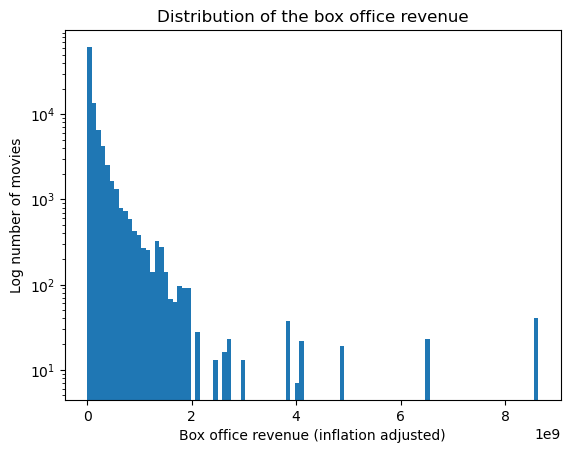

In [40]:
main_column = 'box_office_inflation'

# plot the distribution of the box office revenue
df[main_column].plot(kind='hist', bins=100, legend=False, logy=True)
plt.title('Distribution of the box office revenue')
plt.xlabel('Box office revenue (inflation adjusted)')
plt.ylabel('Log number of movies')
plt.show()

KeyError: 'age_mean'

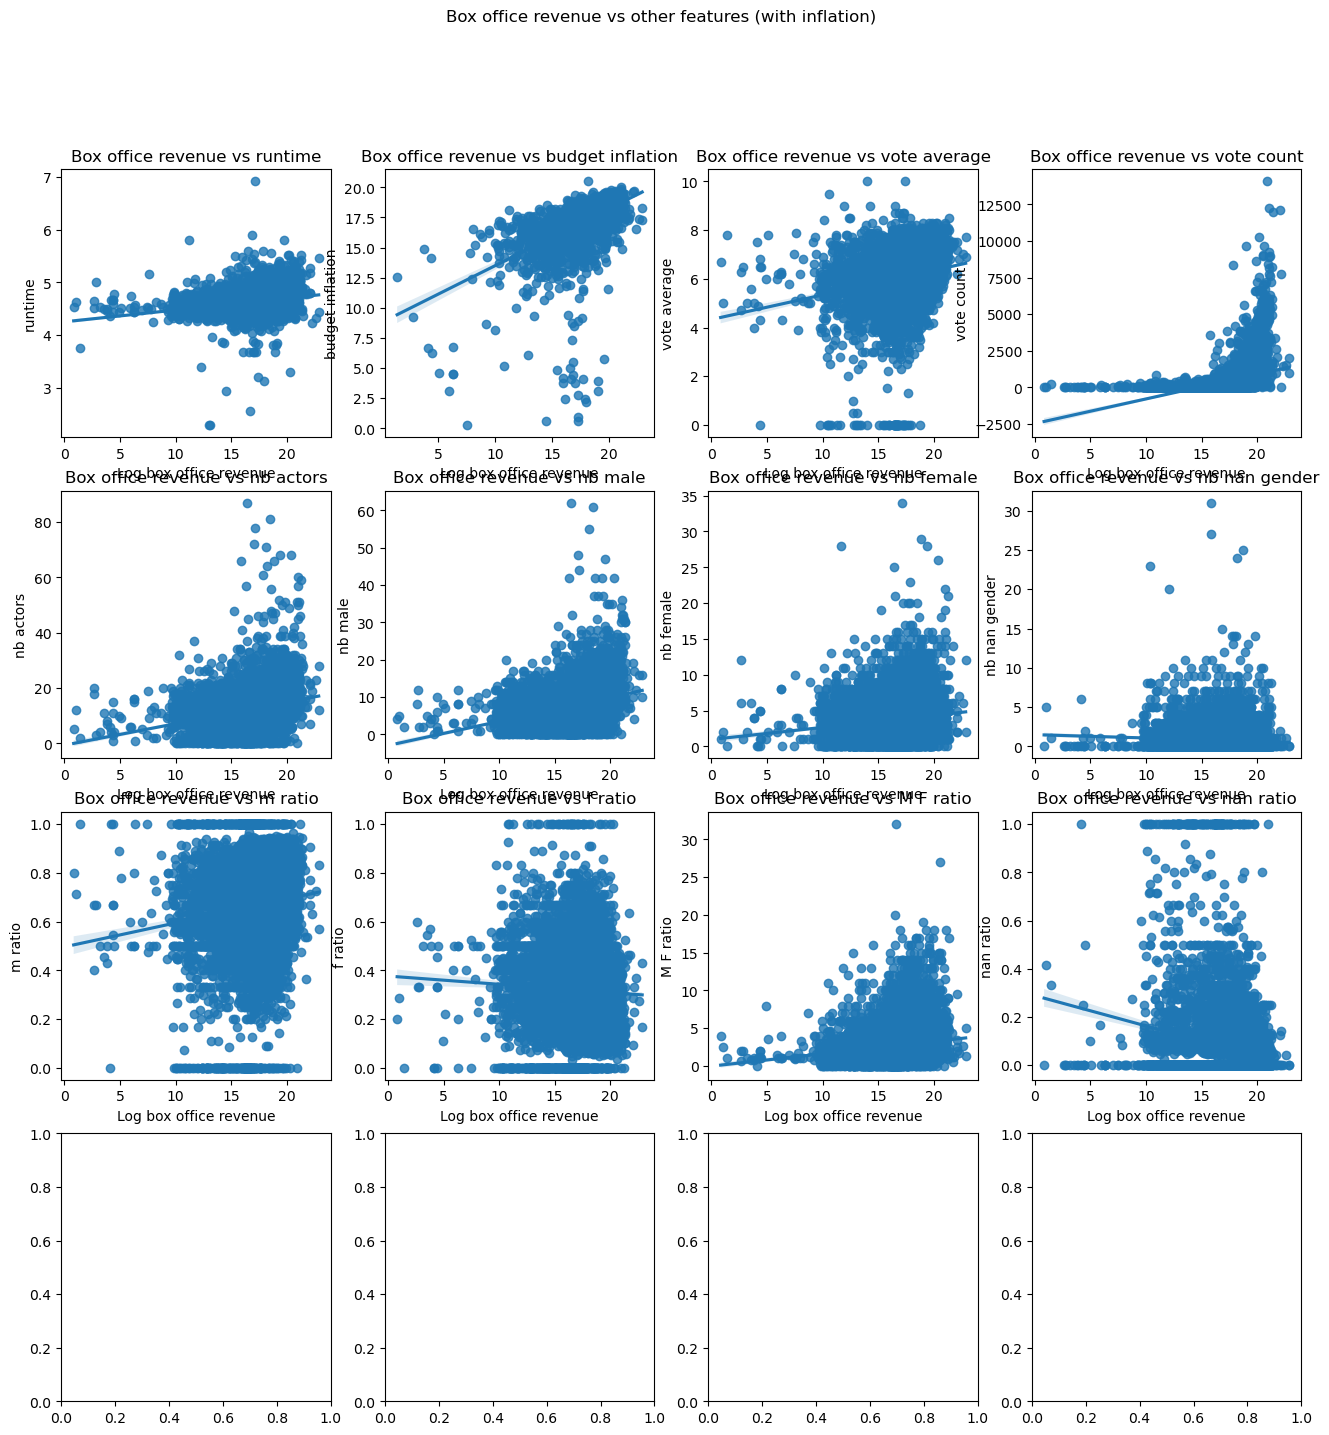

In [41]:
movies_tmp = movies.copy()
# movies_tmp = movies_tmp[movies_tmp['box_office_inflation'] < 2e9]

columns_of_interest = ['runtime', 'budget_inflation', 'vote_average', 'vote_count', 'nb_actors', 'nb_male', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 'M_F_ratio', 'nan_ratio', 'age_mean', 'age_std', 'height_mean', 'height_std']

fig, ax = plt.subplots(len(columns_of_interest)//4, 4, figsize=(16, 16))
ax = ax.flatten()

fig.suptitle('Box office revenue vs other features (with inflation)')

plot_fct = sns.regplot # sns.scatterplot or sns.regplot

# Note: applying logx to the regplot don't apply a log scale to the x axis, but solve a regression
# of the form: y ~ log(x)
log_columns = ['runtime', 'budget_inflation']

movies_tmp[main_column] = np.log(movies_tmp[main_column])
for i, column in enumerate(columns_of_interest):
    if column in log_columns:
        movies_tmp[column] = np.log(movies_tmp[column])

    plot_fct(data=movies_tmp, x=main_column, y=column, ax=ax[i], fit_reg=True) #  , scatter_kws={'alpha':0.15}

    display_name = ' '.join(column.split('_'))
    ax[i].set_title('Box office revenue vs {}'.format(display_name))
    ax[i].set_xlabel('Log box office revenue')
    ax[i].set_ylabel(display_name)

plt.tight_layout()
plt.show()

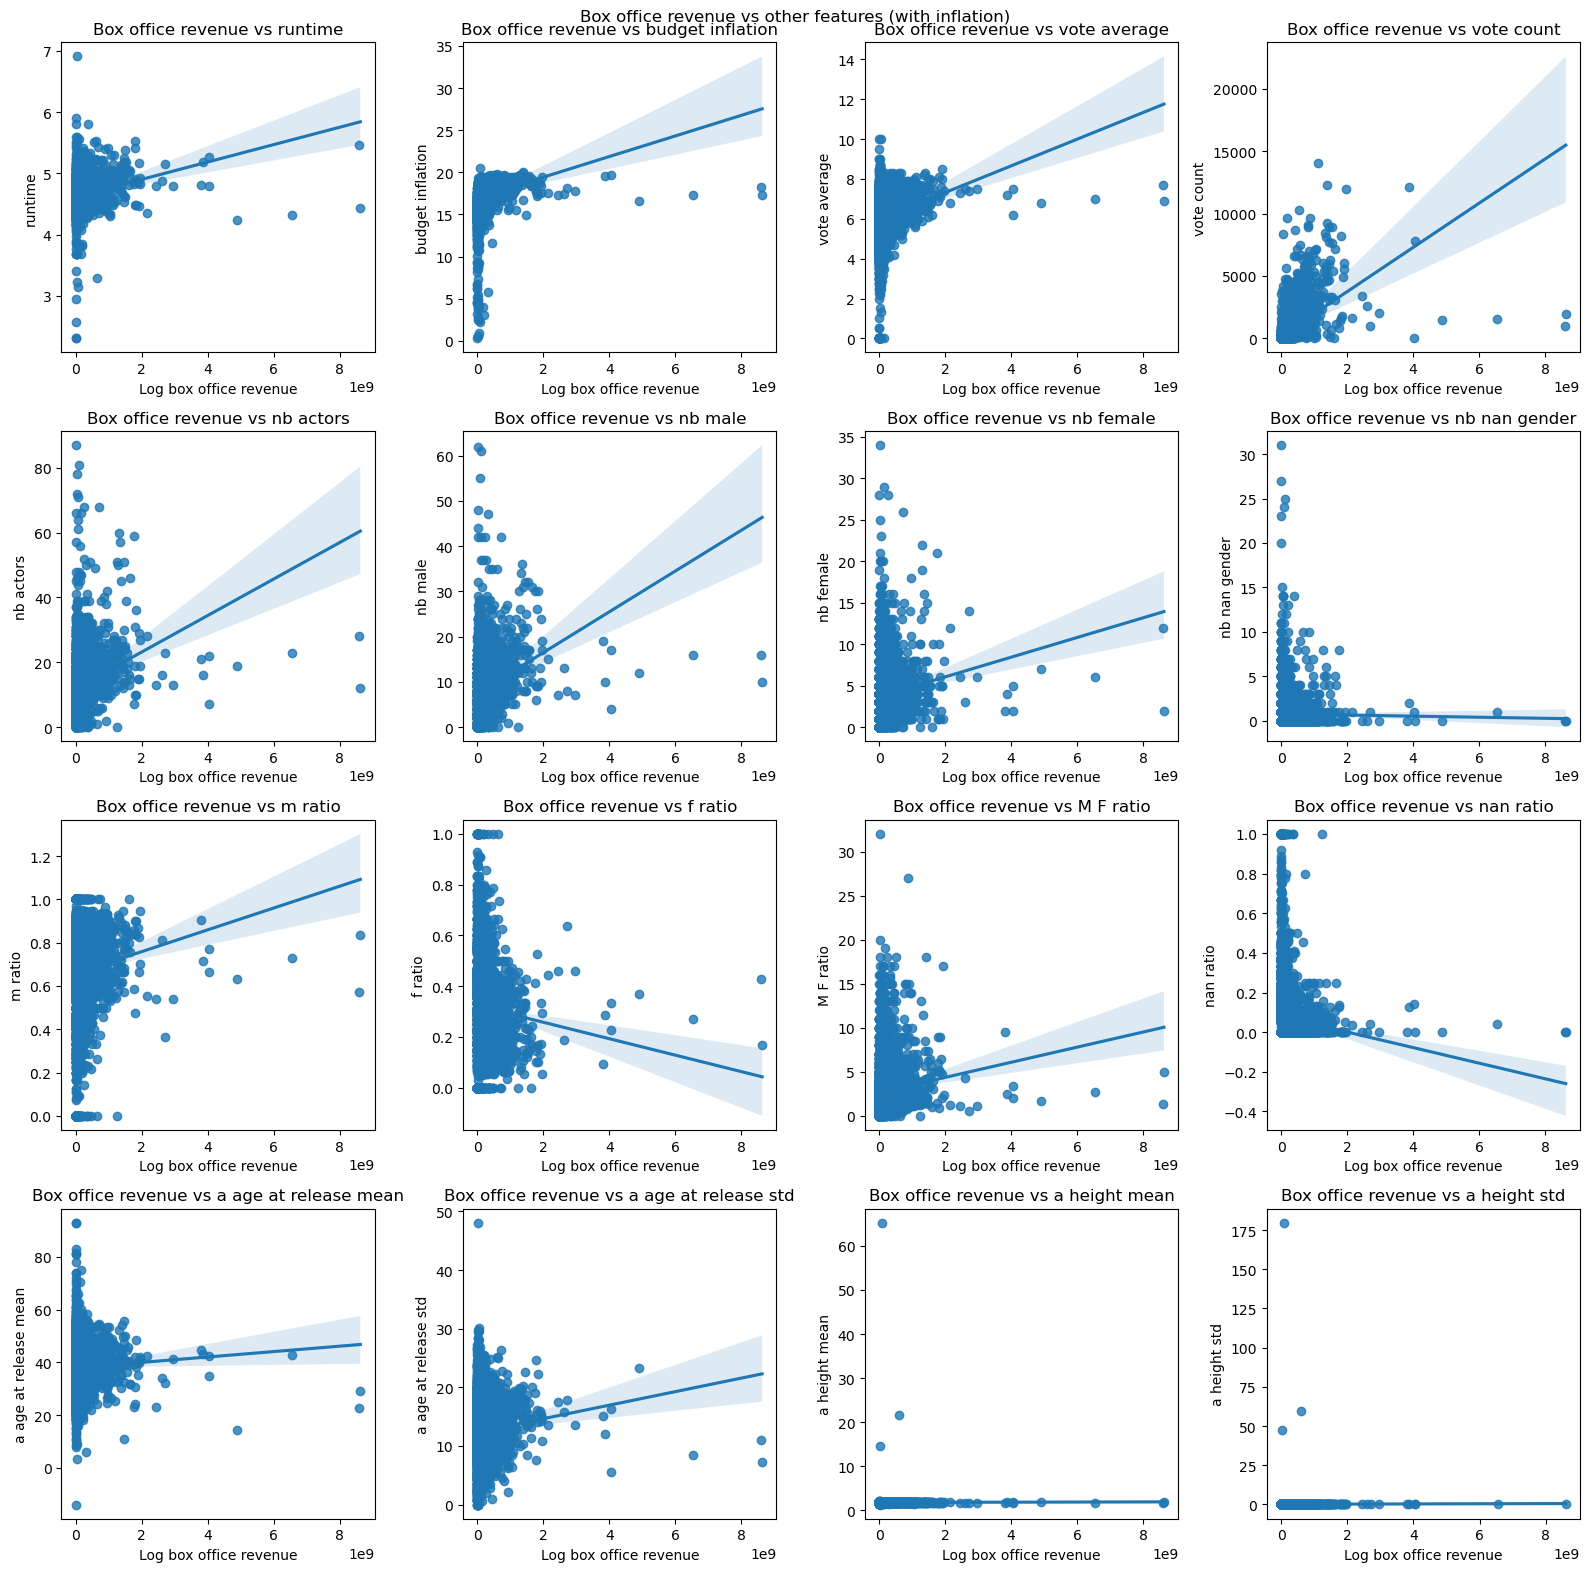

In [55]:
movies_tmp = movies.copy()
# movies_tmp = movies_tmp[movies_tmp['box_office_inflation'] < 2e9]

columns_of_interest = ['runtime', 'budget_inflation', 'vote_average', 'vote_count', 
        'nb_actors', 'nb_male', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 
        'M_F_ratio', 'nan_ratio', 'a_age_at_release_mean', 'a_age_at_release_std', 
        'a_height_mean', 'a_height_std']

fig, ax = plt.subplots(len(columns_of_interest)//4, 4, figsize=(16, 16))
ax = ax.flatten()

fig.suptitle('Box office revenue vs other features (with inflation)')

plot_fct = sns.regplot # sns.scatterplot or sns.regplot

# Note: applying logx to the regplot don't apply a log scale to the x axis, but solve a regression
# of the form: y ~ log(x)
log_columns = ['runtime', 'budget_inflation']

# movies_tmp[main_column] = np.log(movies_tmp[main_column])
for i, column in enumerate(columns_of_interest):
    if column in log_columns:
        movies_tmp[column] = np.log(movies_tmp[column])

    plot_fct(data=movies_tmp, x=main_column, y=column, ax=ax[i], fit_reg=True) #  , scatter_kws={'alpha':0.15}

    display_name = ' '.join(column.split('_'))
    ax[i].set_title('Box office revenue vs {}'.format(display_name))
    ax[i].set_xlabel('Log box office revenue')
    ax[i].set_ylabel(display_name)

plt.tight_layout()
plt.show()

## Statistical analysis

In [ ]:
excluded_covariates = ['vote_average', 'vote_count']
observed_covariates = ' + '.join([col for col in columns_of_interest if col not in excluded_covariates])

formula = '{} ~ {}'.format(main_column, observed_covariates)

mod = smf.ols(formula=formula, data=movies)

np.random.seed(2)
res = mod.fit()

print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     box_office_inflation   R-squared:                       0.229
Model:                              OLS   Adj. R-squared:                  0.226
Method:                   Least Squares   F-statistic:                     81.63
Date:                  Wed, 21 Dec 2022   Prob (F-statistic):          1.53e-190
Time:                          11:37:33   Log-Likelihood:                -74818.
No. Observations:                  3581   AIC:                         1.497e+05
Df Residuals:                      3567   BIC:                         1.498e+05
Df Model:                            13                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.

# Which characteristics of movies are causing high movie box office revenue?
In the following cell, we generate a graph which tries to answer the following question: which characteristics of movies are causing high movie box office revenue?  
We have to keep in mind that we only show a trends between the box office and the other columns of interest. However, this doesn't not means that there's a causation between the two columns, even if the trends suggests that one implies the other! Moreover, this graph presents the whole dataset, and not the trends between the different decades. In order to do a more scientific analysis, we investigate the trends using pair matching further in this notebook.

In [87]:
columns_test = ['runtime', 'budget_inflation', 'vote_average', 'vote_count']
df_test = df[columns_test].copy()

# TODO try to figure out why they all pop at the beginning

# create the interactive figures
fig = go.Figure()

# create one scatter plot of box office revenue vs column
# for each column of interest. Then, link them to the figure
pretty_display = lambda column: ' '.join(column.split('_'))

for column in columns_test: # TODO change
    fig.add_trace(
        go.Scatter(
            x = movies[column],
            y = movies[main_column],
            name = ' '.join(column.split('_')),
            mode = 'markers',
        )
    )

# create the buttons to switch between the different scatter plots
# and link them to the right plot
buttons = []
for column in columns_test:# TODO change
    buttons.append({
        'label': pretty_display(column),
        'method': 'update',
        'args': [{
            'visible': [c == column for c in columns_test],# TODO change
            'title': pretty_display(column),        
            'showlegend':True
        }]
    })
    
# add the figure dropdown menu
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        buttons=buttons,
        showactive=True
        )
    ])

fig.show()

# Did ethnical diversity in successful movies change over time?

In [ ]:
# plot with dropdown of ethnicity % vs box office
# plot of: for each ethnicity (1 plot for each), evolution of the representation over time --> do the mean over 5 years, so 2 means by decade --> can the do mean for all decade at the beginning
#       try a stacked plot for that, if time --> all information in one plot, can be interesting


# Did the gender ratio of the cast in successful movies change over time?


In [ ]:
# almost have the data. Interesing: dual bar plot like before

# Did the age distribution of men and women of the cast in successful movies change over time?

In [ ]:
# stacked plot of the age
# one plot for each age group ?
# reuse most of the code below. Add age statistics (important!)
# if we add the age stats for each movie, this should be much easier to compute

# Does ethnical diversity and gender diversity correlate with the box office revenue?

## Display most represented ethnicities in movies over the whole dataset

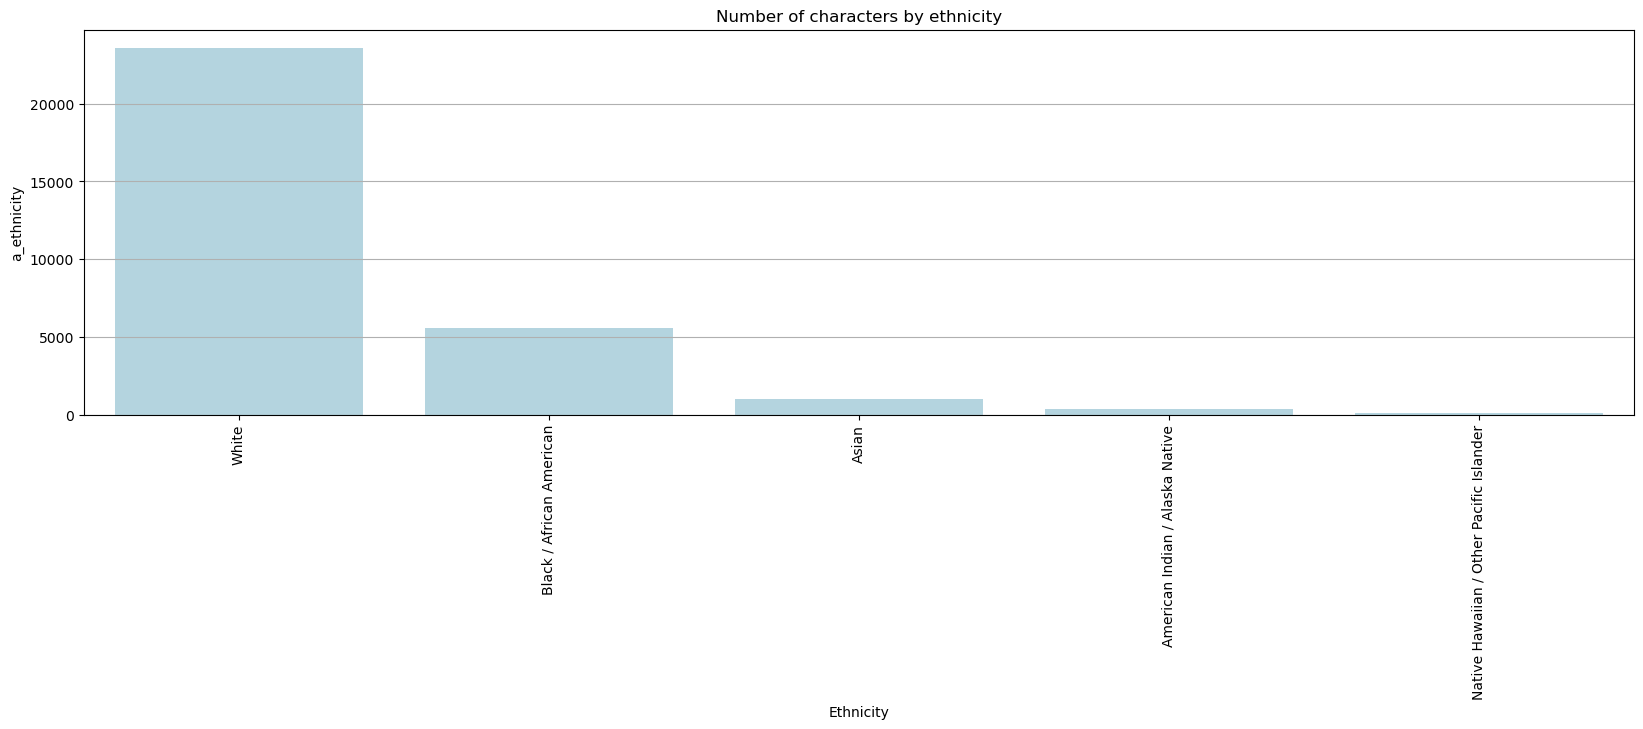

In [ ]:
# plot the number of characters of each ethnicity
ethnicity_count = df['a_ethnicity'].value_counts()
ethnicity_count = ethnicity_count[ethnicity_count > 100]

fig, ax = plt.subplots(figsize=(20, 5))
plt.title('Number of characters by ethnicity') 
sns.barplot(x=ethnicity_count.index, y=ethnicity_count, color='lightblue', ax=ax)
# sns.countplot(x=ethnicity_count, color='lightblue', ax=ax)
ax.set_xlabel('Ethnicity')
plt.xticks(rotation=90)
plt.grid(axis='y') #{'major', 'minor', 'both'}
plt.show()

In [ ]:
# count instances of ethnicities for each year
char_ethnicity = df[~df['a_ethnicity'].isna()]

# from https://stackoverflow.com/questions/17764619/pandas-dataframe-group-year-index-by-decade
ethnicity_count = char_ethnicity.groupby([char_ethnicity['release_date'].dt.year // 10 * 10, char_ethnicity['a_ethnicity']]).count()[['wiki_movie_id']]

# gen a "pretty" and usable dataset
ethnicity_count = ethnicity_count.rename(columns={'wiki_movie_id': 'count'})
ethnicity_count = ethnicity_count.reset_index() # level=1
ethnicity_count = ethnicity_count.rename(columns={'release_date': 'm_release_decade'})
ethnicity_count['m_release_decade'] = ethnicity_count['m_release_decade'].astype(int)
ethnicity_count.head()

,m_release_decade,a_ethnicity,count
0,1910,Black / African American,1
1,1910,White,2
2,1920,Asian,1
3,1920,Black / African American,2
4,1920,Other,2


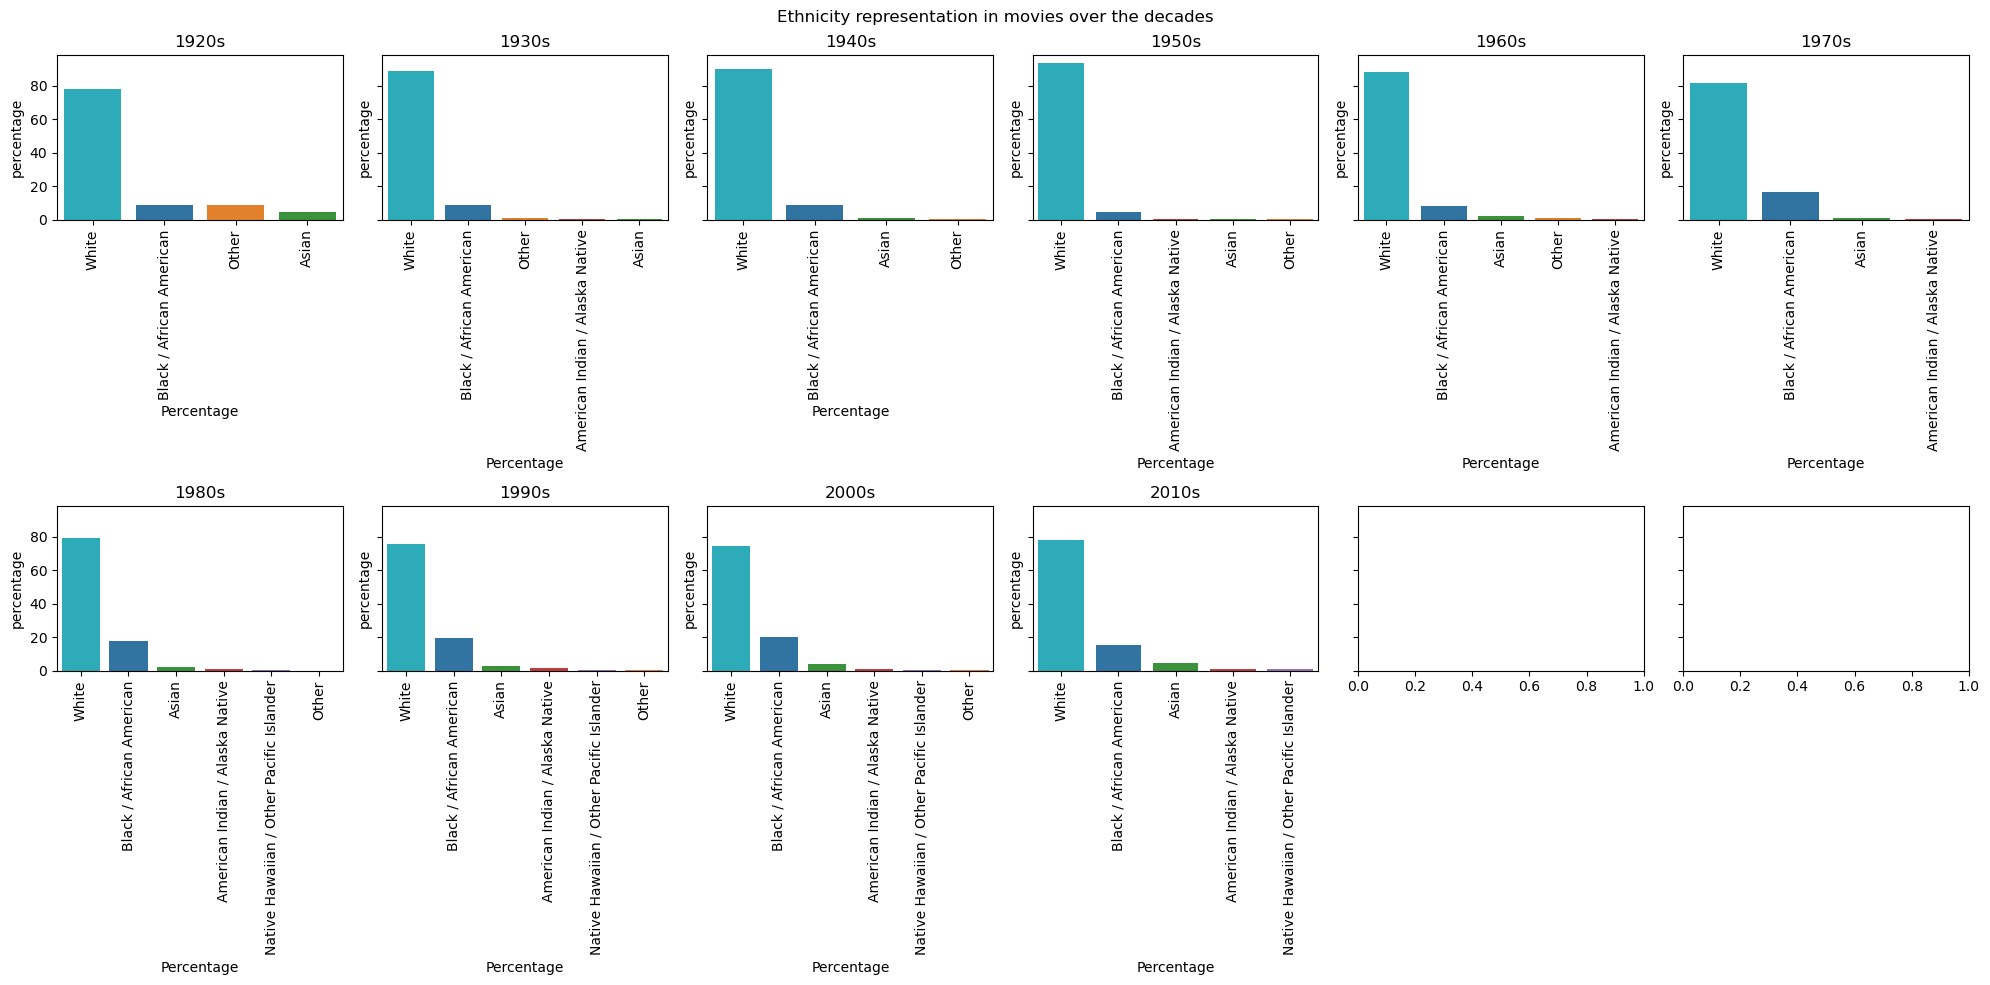

In [ ]:
# get k most represented ethnicites for each decade
top_k = 10
decades = ethnicity_count['m_release_decade'].unique()

fig, ax = plt.subplots(2, 6, figsize=(20, 10), sharey=True)
ax = ax.flatten()
colors = {}

for i, decade in enumerate(decades[1:]):
    # get top k ethnicites
    df_top_k = ethnicity_count[ethnicity_count['m_release_decade'] == decade].sort_values(by='count', ascending=False).head(top_k)

    # percentage of the top k
    total = df_top_k['count'].sum()
    df_top_k['percentage'] = df_top_k['count'].apply(lambda x: x / total * 100)
    
    for ethnicity in df_top_k['a_ethnicity'].values:
        if ethnicity not in colors:
            colors[ethnicity] = sns.color_palette(n_colors=40)[len(colors)-1]

    # plot distribution
    sns.barplot(x=df_top_k['a_ethnicity'], y=df_top_k['percentage'], ax=ax[i], palette=[colors[ethnicity] for ethnicity in df_top_k['a_ethnicity'].values])

    ax[i].set_title('{}s'.format(int(decade)))
    ax[i].set_xlabel('Ethnicity')
    ax[i].set_xlabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

fig.suptitle("Ethnicity representation in movies over the decades")
plt.tight_layout()
plt.show()

# Men/women ratio analysis

In [ ]:
# At the moment, set the ratio to one if the denominator is zero
def compute_men_women_ratio(x):
    genders = x['a_gender']
    nb_actors = x['a_name'].count()
    nb_male = genders[genders == 'M'].count()
    nb_female = genders[genders == 'F'].count()
    nb_nan_gender = genders.isna().sum()

    nb_known_gender = nb_known_gender=nb_male+nb_female
    m_f_ratio = nb_male / nb_female if nb_female > 0 else 1 if nb_male > 0 else 0
    m_ratio = nb_male / nb_known_gender if nb_known_gender > 0 else 0
    f_ratio = nb_female / nb_known_gender  if nb_known_gender > 0 else 0
    nan_ratio = nb_nan_gender / x.shape[0]

    return pd.Series(index=['nb_actors', 'nb_men', 'nb_female', 'nb_nan_gender', 'm_ratio', 'f_ratio', 'M_F_ratio', 'nan_ratio'], data=[nb_actors, nb_male, nb_female, nb_nan_gender, m_ratio, f_ratio, m_f_ratio, nan_ratio])


df_gender = df.groupby('wiki_movie_id').apply(compute_men_women_ratio)

df_gender['nb_actors'] = df_gender['nb_actors'].astype(int)
df_gender['nb_men'] = df_gender['nb_men'].astype(int)
df_gender['nb_female'] = df_gender['nb_female'].astype(int)
df_gender['nb_nan_gender'] = df_gender['nb_nan_gender'].astype(int)
df_gender

,nb_actors,nb_men,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio
wiki_movie_id,,,,,,,,
3217,14,10,3,1,0.769231,0.230769,3.333333,0.071429
3333,14,8,6,0,0.571429,0.428571,1.333333,0.000000
3746,15,11,3,1,0.785714,0.214286,3.666667,0.066667
3837,20,18,2,0,0.900000,0.100000,9.000000,0.000000
3947,15,10,5,0,0.666667,0.333333,2.000000,0.000000
...,...,...,...,...,...,...,...,...
36683360,0,0,0,1,0.000000,0.000000,0.000000,1.000000
36814246,9,2,4,3,0.333333,0.666667,0.500000,0.333333
36929245,0,0,0,1,0.000000,0.000000,0.000000,1.000000


In [ ]:
# get the info of only one movie
df_gender = pd.merge(left=df[['wiki_movie_id', 'release_date']], right=df_gender, how='inner', left_on='wiki_movie_id', right_index=True)
df_gender = df_gender.drop_duplicates('wiki_movie_id')
df_gender['m_release_decade'] = df_gender['release_date'].dt.year // 10 * 10
df_gender
# df2['m_release_decade'].isna().sum()

,wiki_movie_id,release_date,nb_actors,nb_men,nb_female,nb_nan_gender,m_ratio,f_ratio,M_F_ratio,nan_ratio,m_release_decade
0,975900,2001-08-24,17,11,6,0,0.647059,0.352941,1.833333,0.000000,2000.0
17,10408933,1938-08-16,4,2,2,0,0.500000,0.500000,1.000000,0.000000,1930.0
21,77856,1964-08-27,13,7,6,0,0.538462,0.461538,1.166667,0.000000,1960.0
34,612710,1999-10-01,8,4,3,1,0.571429,0.428571,1.333333,0.125000,1990.0
42,156558,2001-06-27,37,11,12,14,0.478261,0.521739,0.916667,0.378378,2000.0
...,...,...,...,...,...,...,...,...,...,...,...
96486,6740261,1939-10-07,11,5,6,0,0.454545,0.545455,0.833333,0.000000,1930.0
96497,54540,1988-06-29,21,15,6,0,0.714286,0.285714,2.500000,0.000000,1980.0
96518,7761830,1990-01-01,9,6,3,0,0.666667,0.333333,2.000000,0.000000,1990.0
96527,1918494,2000-08-26,24,18,4,2,0.818182,0.181818,4.500000,0.083333,2000.0


In [ ]:
# ratio over the whole dataset
print("Male / Female ratio over the whole dataset:", df[df['a_gender'] == 'M'].shape[0] / df[df['a_gender'] == 'F'].shape[0])
print("Nan ratio over the whole dataset:", df[df['a_gender'].isna()].shape[0] / df.shape[0])

Male / Female ratio over the whole dataset: 2.089571053797145
Nan ratio over the whole dataset: 0.06086434200851293


In [ ]:
# mean gender ratio with matching paires
print("Male / Female ratio: :", df_gender['M_F_ratio'].mean())
print("Nan ratio: over bthe whole dataset:", df_gender['nan_ratio'].mean())

Male / Female ratio: : 2.7483569488262343
Nan ratio: over bthe whole dataset: 0.07502256463124722


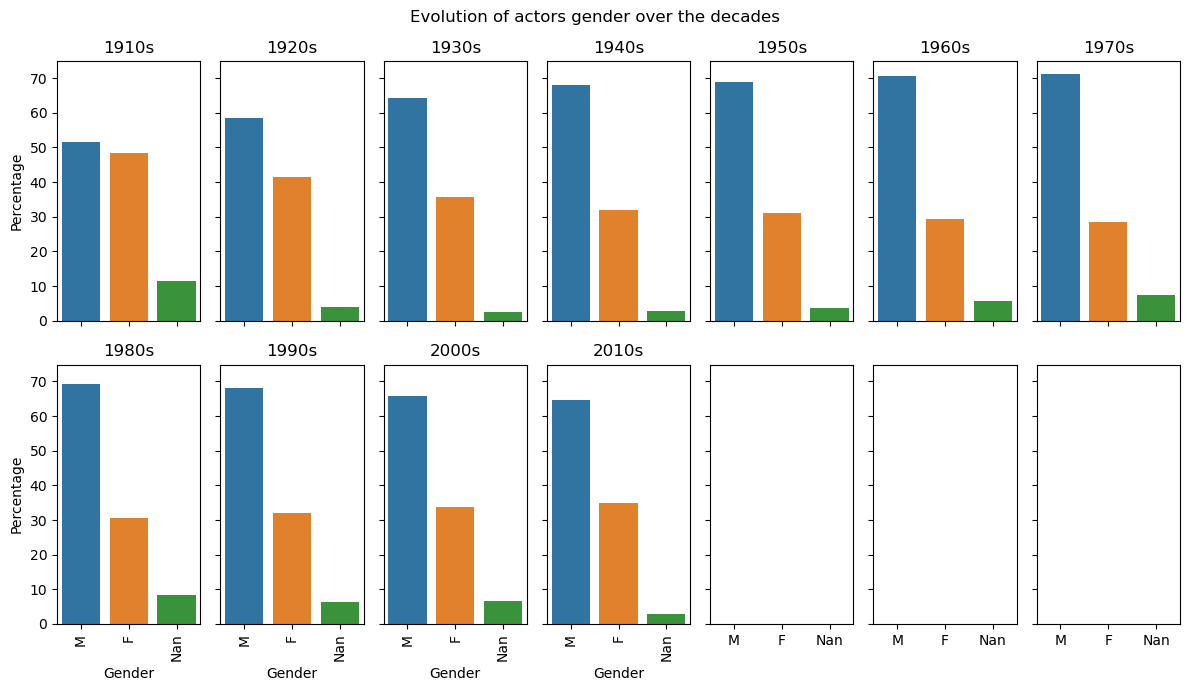

In [ ]:
decades = np.sort(df_gender['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

fig, ax = plt.subplots(2, 7, figsize=(12, 7), sharey=True, sharex=True)
ax = ax.flatten()

for i, decade in enumerate(decades):
    df_decade = df_gender[df_gender['m_release_decade'] == decade]
    
    x = ['M', 'F', 'Nan']
    y = [df_decade['m_ratio'].mean()*100, df_decade['f_ratio'].mean()*100, df_decade['nan_ratio'].mean()*100]

    # plot distribution
    sns.barplot(x=x, y=y, ax=ax[i])

    ax[i].set_title('{}s'.format(int(decade)))

    if i/7 >= 1:
        ax[i].set_xlabel('Gender')

    if i%7 == 0:
        ax[i].set_ylabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

fig.suptitle("Evolution of actors gender over the decades")
plt.tight_layout()
plt.show()



In [ ]:
decades = np.sort(df_gender['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

gender_dict = {}
for i, decade in enumerate(decades):
    df_decade = df_gender[df_gender['m_release_decade'] == decade]
    
    gender_dict[decade] = {
        'M': df_decade['m_ratio'].mean()*100,
        'F': df_decade['f_ratio'].mean()*100
        # 'Nan': df_decade['nan_ratio'].mean()*100
        }

gender_ratio_df = pd.DataFrame(gender_dict)
gender_ratio_df.columns = ['{}s'.format(int(col)) for col in gender_ratio_df.columns]
gender_ratio_df = gender_ratio_df.T
gender_ratio_df.head()

,M,F
1910s,51.615646,48.384354
1920s,58.509275,41.490725
1930s,64.404441,35.595559
1940s,67.903071,32.096929
1950s,68.972360,31.027640


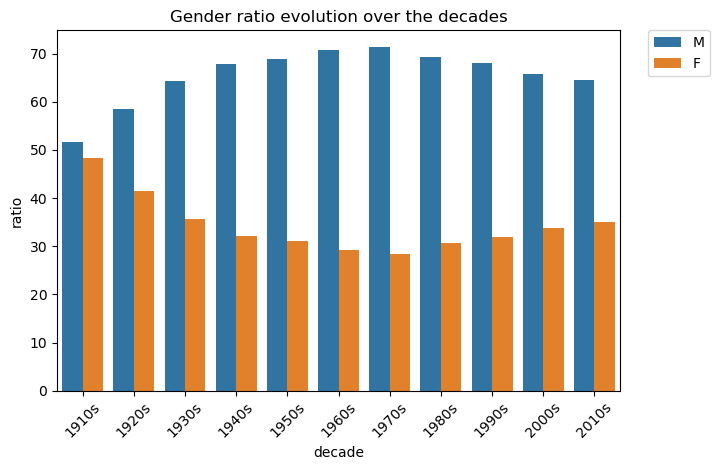

In [ ]:
# pivot table to have one row per gender
plot_df = gender_ratio_df.reset_index()
plot_df = plot_df.rename(columns={'index': 'decade'})
plot_df = plot_df.melt(id_vars='decade', value_vars=['M', 'F'])
plot_df = plot_df.rename(columns={'variable': 'gender', 'value': 'ratio'})

# tmp_df
sns.barplot(data=plot_df, x='decade', y='ratio', hue='gender')
plt.title('Gender ratio evolution over the decades')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Age analysis

In [ ]:
age_df = df.copy()
# here, we suppose that negative ages are just a mistake
age_df['a_age_at_release'] = age_df['a_age_at_release'].abs()
age_df['age_decade_at_release'] = age_df['a_age_at_release'] // 10 * 10
age_df['m_release_decade'] = age_df['release_date'].dt.year // 10 * 10

# age decades
# age_decades = age_df['age_decade_at_release'].value_counts().drop([960.0, 7890.0, 930.0]).index
age_decades = age_df['age_decade_at_release'].value_counts().index
age_decades = np.sort(age_decades)
age_decades

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [ ]:
# Here, we put the 70s+ together
age_df['age_decade_at_release'] = age_df['age_decade_at_release'].replace(to_replace=[80.,  90., 100.], value=70.)
age_decades = age_decades[:-3]

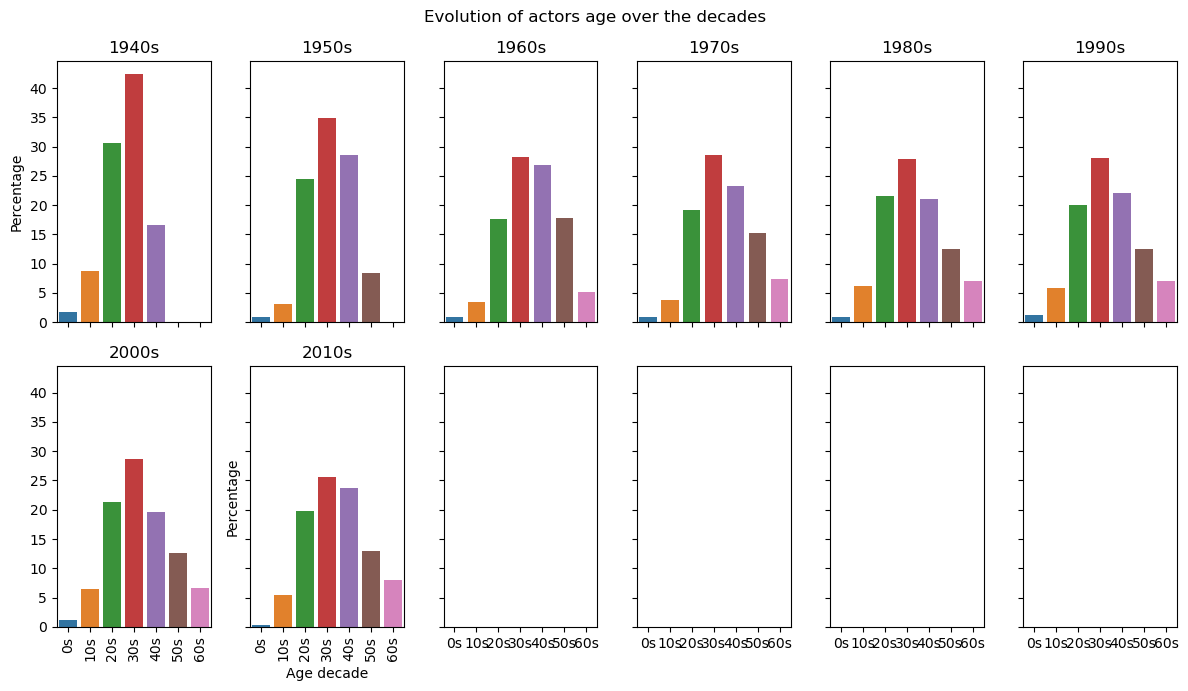

In [ ]:
decades = np.sort(age_df['m_release_decade'].unique())
decades = decades[~np.isnan(decades)]

fig, ax = plt.subplots(2, 6, figsize=(12, 7), sharey=True, sharex=True)
ax = ax.flatten()

for i, decade in enumerate(decades[3:]):
    # get top k ethnicites
    df_decade = age_df[age_df['m_release_decade'] == decade]
    df_decade = df_decade[~df_decade['age_decade_at_release'].isna()]

    x = []
    y = []
    for age_decade in age_decades:
        if age_decade == 70:
            x.append('70+')
        else:
            x.append('{}s'.format(int(age_decade)))
        y.append(df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100)

    # plot distribution
    sns.barplot(x=x, y=y, ax=ax[i], palette='tab10')

    ax[i].set_title('{}s'.format(int(decade)))

    if i/7 >= 1:
        ax[i].set_xlabel('Age decade')

    if i%7 == 0:
        ax[i].set_ylabel('Percentage')

    # before legend
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90) 

plt.suptitle("Evolution of actors age over the decades")
plt.tight_layout()
plt.show()

In [ ]:
age_decades_dict = {}

for i, decade in enumerate(decades[3:]):
    # get top k ethnicites
    df_decade = age_df[age_df['m_release_decade'] == decade]
    df_decade = df_decade[~df_decade['age_decade_at_release'].isna()]
    
    row = {}
    for age_decade in age_decades:
        if age_decade == 70:
            col_name = '70s+'
        else:
            col_name = '{}s'.format(int(age_decade))

        if col_name in row:
            row[col_name].update(df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100)
        else:
            row[col_name] =  df_decade[df_decade['age_decade_at_release'] == age_decade].shape[0] / df_decade.shape[0] * 100

    age_decades_dict[decade] = row

In [ ]:
# pd.DataFrame(index='decage', columns=['{}s'.format(age_decade) for age_decade in age_decades])
age_decades_df = pd.DataFrame(age_decades_dict)
age_decades_df.columns = ['{}s'.format(int(col)) for col in age_decades_df.columns]
age_decades_df = age_decades_df.T
age_decades_df.columns = ['0-9 y.o.', '10-19 y.o.', '20-29 y.o.', '30-39 y.o.', '40-49 y.o.', '50-59 y.o.', '60-69 y.o.', '70+ y.o.']

ValueError: Length mismatch: Expected axis has 7 elements, new values have 8 elements

In [ ]:
# Potentially interesting: area, bar, pie (but for each of them independently)
# age_decades_df.plot(kind='bar', stacked=True)
age_decades_df.plot(kind='bar', stacked=True)

plt.xticks(rotation=90)
plt.xlabel('Decade')
plt.ylabel('Percentage')
plt.title('Actor age distribution over the decades')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.show()